In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../bird_view')
import utils

In [2]:
#use classes provided by researchers to process data.
from utils.datasets import BirdViewDataset, ImageDataset

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
data_path = '/Users/ck/data_local/lbc/'
bv_ds = BirdViewDataset(data_path)
print()
im_ds = ImageDataset(data_path)


/Users/ck/data_local/lbc/: 1513 frames, 1 episodes.

augment with  None
Finished loading /Users/ck/data_local/lbc/. Length: 1513


# for visualizing segmentation

In [4]:
from __future__ import print_function
import torch
import numpy as np
from PIL import Image
import numpy as np
import os
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import cv2

##############################################################################
# Code from
# https://github.com/ycszen/pytorch-seg/blob/master/transform.py
# Modified so it complies with the Citscape label map colors
###############################################################################

def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])

def labelcolormap(N):
    '''
    returns a numpy array representing a mapping: cmap[class][0] = r, cmap[class][1] = g, cmap[class][2] = b
    '''
    if N == 35: # cityscape
        cmap = np.array([(  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (111, 74,  0), ( 81,  0, 81),
                     (128, 64,128), (244, 35,232), (250,170,160), (230,150,140), ( 70, 70, 70), (102,102,156), (190,153,153),
                     (180,165,180), (150,100,100), (150,120, 90), (153,153,153), (153,153,153), (250,170, 30), (220,220,  0),
                     (107,142, 35), (152,251,152), ( 70,130,180), (220, 20, 60), (255,  0,  0), (  0,  0,142), (  0,  0, 70),
                     (  0, 60,100), (  0,  0, 90), (  0,  0,110), (  0, 80,100), (  0,  0,230), (119, 11, 32), (  0,  0,142)],
                     dtype=np.uint8)
    else:
        cmap = np.zeros((N, 3), dtype=np.uint8)
        for i in range(N):
            r, g, b = 0, 0, 0
            id = i
            for j in range(7):
                str_id = uint82bin(id)
                r = r ^ (np.uint8(str_id[-1]) << (7-j))
                g = g ^ (np.uint8(str_id[-2]) << (7-j))
                b = b ^ (np.uint8(str_id[-3]) << (7-j))
                id = id >> 3
            cmap[i, 0] = r
            cmap[i, 1] = g
            cmap[i, 2] = b
    return cmap

class Colorize(object):
    def __init__(self, n=35):
        self.cmap = labelcolormap(n)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        '''
        gray_image: 1 x H x W (expected to be tensor with channel dim before w and h)
        '''
        # import pdb; pdb.set_trace()
        shape = gray_image.shape
        color_image = torch.ByteTensor(3, shape[1], shape[2]).fill_(0)

        for label in range(len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image

class ColorizeNumpy(object):
    def __init__(self, n=35):
        self.cmap = labelcolormap(n)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        '''
        gray_image: H x W
        '''
        # import pdb; pdb.set_trace()
        shape = gray_image.shape
        color_image = np.zeros(shape=[shape[0], shape[1], 3], dtype=np.uint8)

        for label in range(len(self.cmap)):
            mask = (label == gray_image)
            color_image[mask, 0] = self.cmap[label][0]
            color_image[mask, 1] = self.cmap[label][1]
            color_image[mask, 2] = self.cmap[label][2]

        return color_image

color = ColorizeNumpy(19)
def colorize(gray_img):
    return color(gray_img)

CITYSCAPES_CLASSES = {
    0: [0, 0, 0],  # None
    1: [70, 70, 70],  # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],  # Other
    4: [220, 20, 60],  # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],  # RoadLines
    7: [128, 64, 128],  # Roads
    8: [244, 35, 232],  # Sidewalks
    9: [107, 142, 35],  # Vegetation
    10: [0, 0, 255],  # Vehicles
    11: [102, 102, 156],  # Walls
    12: [220, 220, 0]  # TrafficSigns
}

def as_cityscapes_palette(frame):
    """ Transforms the frame to the Carla cityscapes pallete.

    Note: this conversion is slow.
    """
    result = np.zeros((frame.shape[0], frame.shape[1], 3),
                      dtype=np.uint8)
    for key, value in CITYSCAPES_CLASSES.items():
        result[np.where(frame == key)] = value
    return result

<h1>Using BirdViewDataset</h1>

In [5]:
print('each entry in bird view dataset:\n')
print(type(bv_ds[0]), len(bv_ds[0]))
for e in bv_ds[0]:
    print('\t' + str(type(e)))
print("\nsize of torch.Tensor:")
print(bv_ds[0][0].size())

each entry in bird view dataset:

<class 'tuple'> 4
	<class 'torch.Tensor'>
	<class 'numpy.ndarray'>
	<class 'numpy.float32'>
	<class 'numpy.float32'>

size of torch.Tensor:
torch.Size([7, 192, 192])


all seven items of interest combined


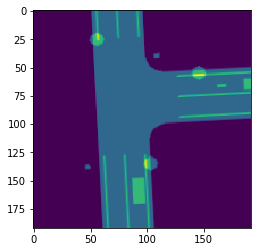

<Figure size 432x288 with 0 Axes>

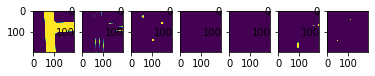

In [6]:
FRAME_bv = 236
bvmap = np.array(bv_ds[FRAME_bv][0])
bvmap_condensed = np.sum(bvmap, axis=0)
print("all seven items of interest combined")
plt.imshow(bvmap_condensed);

plt.figure()
f, axarr = plt.subplots(1,7) 
for i in range(7):
    axarr[i].imshow(bvmap[i])

<h1>Using ImageDataset</h1>

In [7]:
print('each entry in image dataset:\n')
print(type(im_ds[0]), len(im_ds[0]))
for e in im_ds[0]:
    print('\t' + str(type(e)))
print("\nsize of torch.Tensors:")
print(im_ds[0][0].size())
print(im_ds[0][1].size())

each entry in image dataset:

<class 'tuple'> 5
	<class 'torch.Tensor'>
	<class 'torch.Tensor'>
	<class 'numpy.ndarray'>
	<class 'numpy.float32'>
	<class 'numpy.float32'>

size of torch.Tensors:
torch.Size([3, 512, 1280])
torch.Size([7, 192, 192])


all seven items of interest combined
(array([0.        , 0.01176471, 0.05490196, 0.0627451 , 0.08235294,
       0.10588235, 0.11764706, 0.14901961, 0.16470589, 0.2784314 ,
       0.3882353 , 0.39215687, 0.49803922, 0.5058824 , 0.5176471 ,
       0.5803922 , 0.59607846, 0.60784316, 0.62352943, 0.627451  ,
       0.63529414, 0.67058825, 0.6901961 , 0.7176471 , 0.72156864,
       0.7607843 , 0.78431374, 0.79607844, 0.83137256, 0.85882354,
       0.8980392 , 0.9411765 , 0.9529412 , 0.96862745, 1.        ],
      dtype=float32), array([21210,     1,     2,     1,     2,     1,     1,     1,   325,
           1,     2,     1,     2,     1,     1,     1,     1,     3,
           1,     1,     1,     2,     1,     3,     3,     1,     1,
           1,   258,     1,     1,     1,     2,     1, 15028]))
(array([0.        , 0.04313726, 0.0627451 , 0.09803922, 0.13333334,
       0.16470589, 0.23529412, 0.3882353 , 0.4745098 , 0.5058824 ,
       0.60784316, 0.6117647 , 0.83137256, 1.        ], dtyp

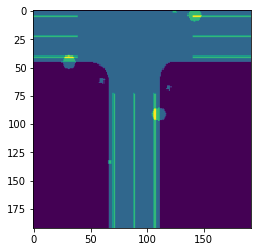

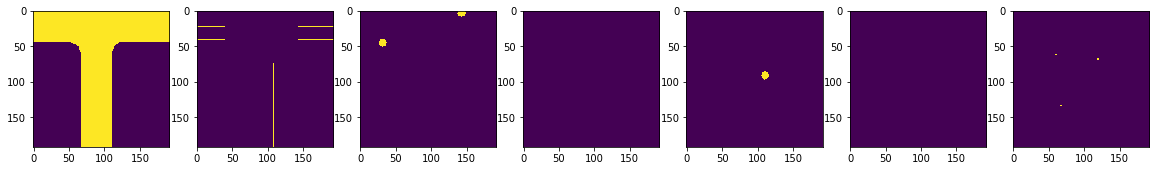

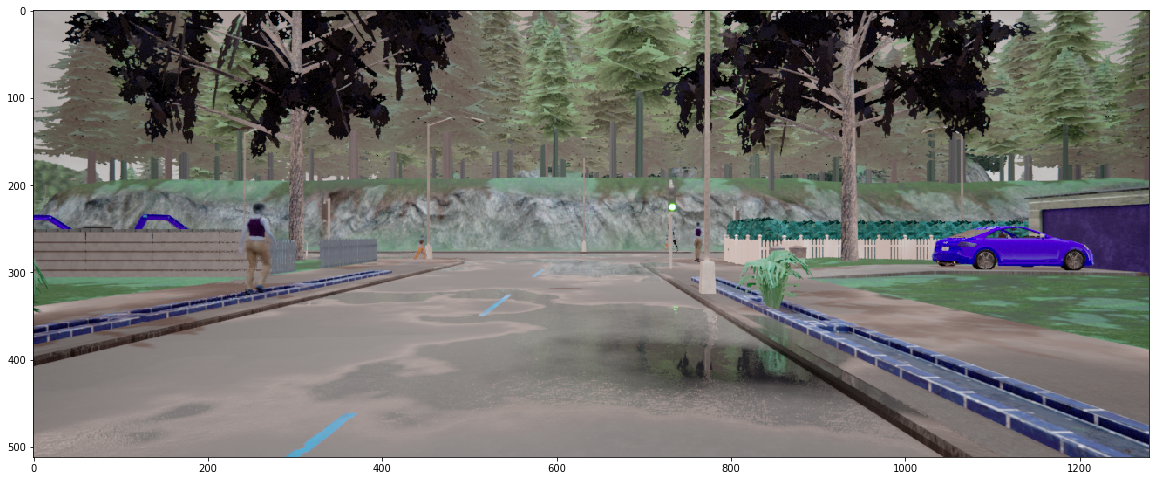

In [9]:
FRAME_im = 0
for FRAME_im in range(0, 300, 10):
    bvmap = np.array(im_ds[FRAME_im][1])
    bvmap_condensed = np.sum(bvmap, axis=0)
    print("all seven items of interest combined")
    plt.figure()
    plt.imshow(bvmap_condensed);

    f, axarr = plt.subplots(1,7, figsize=[20, 10])
    #map for each channel
#     for i in range(7):
#         axarr[i].imshow(bvmap[i] > 0.9)
#         print(np.unique(bvmap[i], return_counts=True))
    
    
    immap = np.array(im_ds[FRAME_im][0])
    # (channels, width, height) -> (width, height, channels)
    plt.figure(figsize=[20, 10])
    plt.imshow(np.moveaxis(immap, 0, -1)[:, :, ::-1])
    break

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.9607843  0.9647059  0.96862745
 0.972549   0.9764706  0.98039216 0.9843137  0.9882353  0.99215686
 0.99607843 1.        ]


torch.Size([7, 200, 200])

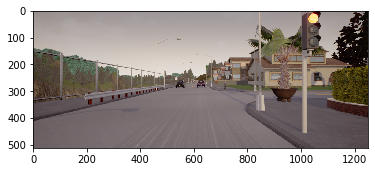

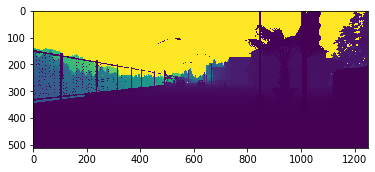

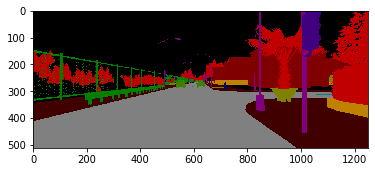

In [94]:
immap = np.array(im_ds[FRAME_im][0])
# (channels, width, height) -> (width, height, channels)
plt.figure()
plt.imshow(np.moveaxis(immap, 0, -1)[:, :, ::-1])

d = np.array(im_ds[FRAME_im][-2]) / 100
d = np.moveaxis(d, 0, -1)
d = d[:, :, 0]
plt.figure()
plt.imshow(d)

s = np.array(im_ds[FRAME_im][-1])[0, :, :]
s = colorize(s)
plt.figure()
plt.imshow(s)

print(np.unique(im_ds[FRAME_im][1]))
im_ds[FRAME_im][1].shape

In [86]:
ck = bvmap.transpose(1, 2, 0)
def colorize_bevseg(bv):
    '''
    bev assumed to be np of asize h, w, 7
    :param bv:
    :type bv:
    :return:
    :rtype:
    '''
    bev_rgb_shape = list(bv.shape)
    bev_rgb_shape[-1] = 3
    img = np.zeros(bev_rgb_shape)
    img[..., 0] = bv[..., 0]
    img[..., 1] = bv[..., 1]
    img[..., 2] = np.sum(bv[..., 2:], axis=2)
    return img * 255
ck = colorize_bevseg(ck)
cv2.imwrite('/Users/ck/Downloads/ck.png', ck)
                         


True